In [1]:
from PIL import Image
import numpy as np
import joblib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import warnings

# Increase the pixel size limit
Image.MAX_IMAGE_PIXELS = 1000000000  # Increase this value as needed

# Random generator seed
rng = np.random.default_rng(seed = 0)

In [2]:
# Load RGB and thermal images
rgb_zone1 = Image.open("datasets/rgb_zone1.png").convert("RGB")
thermal_zone1 = Image.open("datasets/thermal_zone1.png").convert("RGB")
rgb_zone2 = Image.open("datasets/rgb_zone2.png").convert("RGB")

# Convert images to numpy arrays
rgb_zone1_array = np.array(rgb_zone1)
thermal_zone1_array = np.array(thermal_zone1)
rgb_zone2_array = np.array(rgb_zone2)

In [3]:
# Load thermal patches and centers from the pickle file
with open("datasets/uav.pkl", "rb") as f:
    uav_data = joblib.load(f)
thermal_patches = uav_data['anchor']  
centers = uav_data['center']

In [4]:
def get_random_crop_trainset(rgb_base_array,thermal_base_array, crop_size = 1536, patch_size = 512, blend_ratio = 0.5):
    """
        Given two base images and patch and crop sizes (rgb, thermal, crop_size, patch_size)
        generates random rgb_crop with crop_size, and a random thermal_patch with patch_size

        returns crop, patch and all coordinates used to generate crops.
    """
    h, w, _ = rgb_base_array.shape
    
    rgb_random_top = rng.integers(0, h - crop_size)
    rgb_random_left = rng.integers(0, w - crop_size)
    
    patch_random_top = rng.integers(0, crop_size - patch_size)
    patch_random_left = rng.integers(0, crop_size - patch_size)
    
    # local center in rgb_crop (convention used x,y!)
    patch_rgb_crop_local_center = (patch_random_left + patch_size // 2 , patch_random_top + patch_size // 2)
    patch_rgb_base_center = rgb_random_left + patch_rgb_crop_local_center[0], rgb_random_top + patch_rgb_crop_local_center[1]
    
    
    crop_top = rgb_random_top
    crop_bottom = rgb_random_top + crop_size
    crop_left = rgb_random_left
    crop_right = rgb_random_left + crop_size
    
    patch_top = crop_top + patch_random_top 
    patch_bottom = crop_top + patch_random_top + patch_size
    patch_left = crop_left + patch_random_left
    patch_right = crop_left + patch_random_left + patch_size
    
    rgb_crop = rgb_base_array[crop_top:crop_bottom,crop_left:crop_right]
    
    thermal_patch = thermal_base_array[patch_top:patch_bottom, patch_left:patch_right] 
    
    # Overlay the thermal patch on the cropped RGB image
    overlay = rgb_crop.copy()
    
    # Ensure the thermal patch fits within the cropped RGB area
    overlay[
        patch_random_top:patch_random_top + patch_size,
        patch_random_left:patch_random_left + patch_size
    ] = (1-blend_ratio) * overlay[
        patch_random_top:patch_random_top + patch_size,
        patch_random_left:patch_random_left + patch_size
    ] + blend_ratio * thermal_patch  # Directly blend the RGB thermal patch


    return {
        "rgb_crop": rgb_crop, 
        "thermal_patch":thermal_patch, 
        "patch_center_base":patch_rgb_base_center, 
        "patch_center_crop":patch_rgb_crop_local_center,
        "patch_base_top": patch_top,
        "patch_base_left": patch_left,
        "rgb_base_top": crop_top,
        "rgb_base_left": crop_left,
        "patch_crop_top": patch_random_top,
        "patch_crop_left": patch_random_left,
        "overlay":overlay}

def get_random_crop_testset(center, 
                             rgb_base_array, 
                             thermal_patch, 
                             thermal_patch_size = 512, 
                             crop_size = 1536, 
                             blend_ratio=0.5):
    """
    Generates random crops from rgb base with their associated thermal patches in test dataset given the center (x, y)

    returns center, rgb_crop, thermal_patch, rgb_top, rgb_left, thermal_top, thermal_left
    """
    # Get height and width
    h, w, _ = rgb_base_array.shape
    # This is the center within the rgb_base (convention used in the dataset is x,y, not y,x!)
    center_x, center_y = center
    
    # Dimensions of the thermal patch
    thermal_top = center_y - thermal_patch_size // 2
    thermal_bottom = center_y + thermal_patch_size // 2
    thermal_left = center_x - thermal_patch_size // 2
    thermal_right = center_x + thermal_patch_size // 2

    # Calculate random crop bounds
    top_min = max(0, thermal_bottom - crop_size)
    top_max = min(h - crop_size, thermal_top)
    left_min = max(0, thermal_right - crop_size)
    left_max = min(w - crop_size, thermal_left)

    # Sample random top and left ensuring the thermal patch is included
    top = rng.integers(top_min, top_max + 1)
    left = rng.integers(left_min, left_max + 1)
    
    # Extract the cropped RGB image
    rgb_crop = rgb_base_array[top:top + crop_size, left:left + crop_size]

    # Overlay the thermal patch on the cropped RGB image
    overlay = rgb_crop.copy()

    # Define the location of the thermal patch in the cropped RGB coordinates
    thermal_top_in_crop = thermal_top - top
    thermal_left_in_crop = thermal_left - left
    
    # Ensure the thermal patch fits within the cropped RGB area
    overlay[
        thermal_top_in_crop:thermal_top_in_crop + thermal_patch_size,
        thermal_left_in_crop:thermal_left_in_crop + thermal_patch_size,
        :
    ] = (1-blend_ratio) * overlay[
        thermal_top_in_crop:thermal_top_in_crop + thermal_patch_size,
        thermal_left_in_crop:thermal_left_in_crop + thermal_patch_size,
        :
    ] + blend_ratio * thermal_patch  # Directly blend the RGB thermal patch

        
    return {
        "rgb_crop": rgb_crop, 
        "thermal_patch":thermal_patch, 
        "patch_center_base":center, 
        "patch_center_crop": (thermal_left_in_crop + thermal_patch_size // 2 , thermal_top_in_crop + thermal_patch_size // 2),
        "patch_base_top": thermal_top,
        "patch_base_left": thermal_left,
        "rgb_base_top": top,
        "rgb_base_left": left,
        "patch_crop_top": thermal_top_in_crop,
        "patch_crop_left": thermal_left_in_crop,
        "overlay":overlay
    }
    return center, rgb_crop, thermal_patch, top, left, thermal_top, thermal_left

In [5]:
rng = np.random.default_rng(seed = 0)
item = get_random_crop_trainset(rgb_zone1_array,thermal_zone1_array)

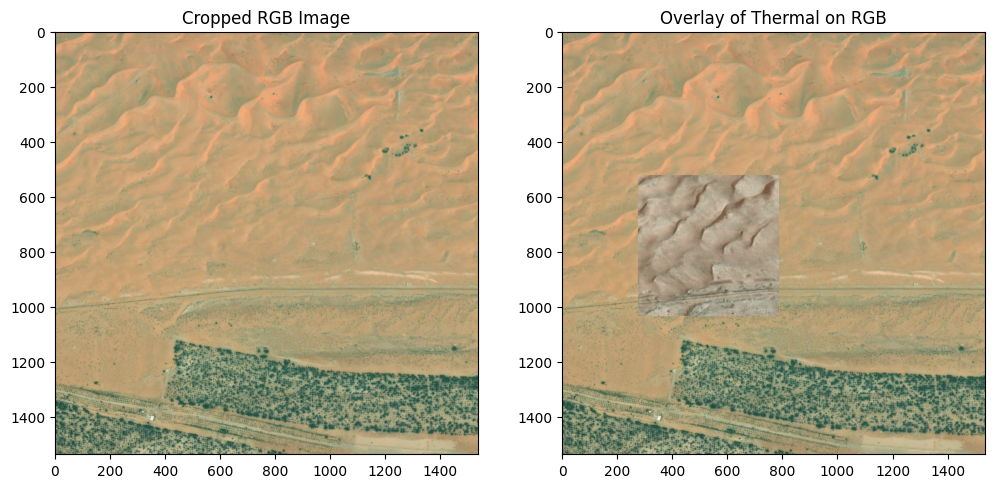

In [6]:
# Plot the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Cropped RGB Image")
plt.imshow(item["rgb_crop"].astype(np.uint8))  # Display the cropped RGB image

plt.subplot(1, 2, 2)
plt.title("Overlay of Thermal on RGB")
plt.imshow(item["overlay"].astype(np.uint8))  # Display the blended overlay
plt.show()

In [21]:
item = get_random_crop_testset(centers[434],rgb_zone2_array, thermal_patches[434])

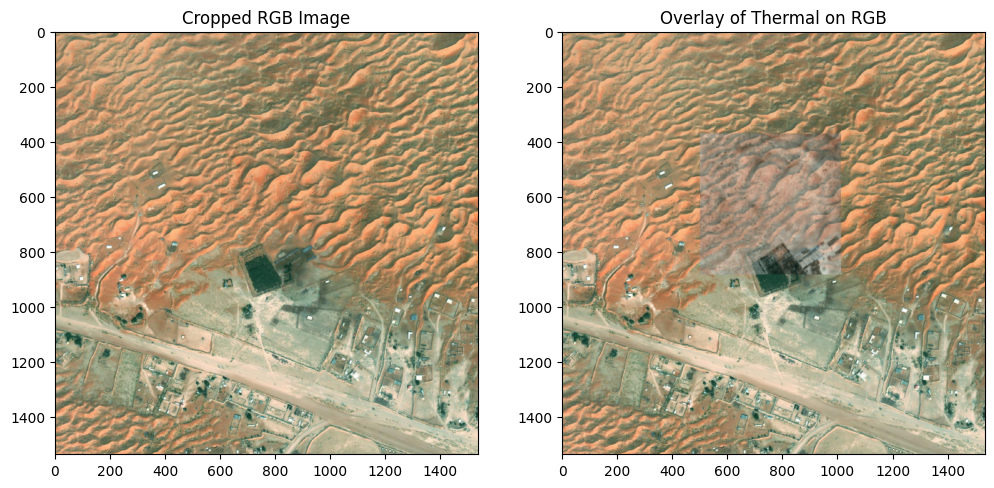

In [22]:
# Plot the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Cropped RGB Image")
plt.imshow(item["rgb_crop"].astype(np.uint8))  # Display the cropped RGB image

plt.subplot(1, 2, 2)
plt.title("Overlay of Thermal on RGB")
plt.imshow(item["overlay"].astype(np.uint8))  # Display the blended overlay
plt.show()

In [23]:
class Trainset(Dataset):
    def __init__(self, 
                 rgb_base_path, 
                 thermal_base_path, 
                 num_samples = 1000, 
                 rgb_transforms = None, 
                 thermal_tranforms=None, 
                 patch_size=512, 
                 crop_size=1536):
        # Get image
        self.rgb_base = Image.open(rgb_base_path).convert("RGB")
        self.thermal_base = Image.open(thermal_base_path).convert("RGB")
        # Get sizes
        self.crop_size = crop_size
        self.patch_size = patch_size
        # Get transformations (For homography transformations)
        self.rgb_transforms = rgb_transforms
        self.thermal_tranforms = thermal_tranforms
        # Get how many samples to generate
        self.num_samples = num_samples
        # Generated sampled will be hold in a list
        self.samples = []
        # Generate samples. 
        self._getsamples()
        
    def __len__(self,):
        return self.num_samples

    def _getsamples(self):
        # Convert RGB PIL image to numpy array
        rgb_base_array = np.array(self.rgb_base)
        thermal_base_array = np.array(self.thermal_base) 
        
        # Iteratively generate random crops from the base images.
        for item in range(self.num_samples):
            self.samples.append(get_random_crop_trainset(rgb_base_array, 
                                                         thermal_base_array, 
                                                         self.crop_size, 
                                                         self.patch_size)
                               )    
    def __getitem__(self,idx):
        item = self.samples[idx]
        
        # Apply rgb image transformations if applies (maybe contrast enhancement etc..)
        if self.rgb_transforms:
            item = self.rgb_transforms(item)
            
        # Apply thermal patch transformations if applied (Homography transformations)
        if self.thermal_tranforms:
            # Necessary coordinate transformations will be inside thermal_transforms pipeline.
            item = self.thermal_tranforms(item)

        return item


class Testset(Dataset):
    def __init__(self, 
                 rgb_base_path, 
                 thermal_patches, 
                 centers,
                 num_samples = 1000,
                 rgb_transforms = None, 
                 thermal_tranforms=None, 
                 patch_size=512, 
                 crop_size=1536):
        # Get image
        self.rgb_base = Image.open(rgb_base_path).convert("RGB")
        # get thermal patches
        self.thermal_patches = thermal_patches
        # get number of samples to generate
        self.num_samples = num_samples
        # get centers
        self.centers = centers 
        # Get sizes
        self.crop_size = crop_size
        self.patch_size = patch_size
        # Get transformations (For homography transformations)
        self.rgb_transforms = rgb_transforms
        self.thermal_tranforms = thermal_tranforms
        # Generated sampled will be hold in a list
        self.samples = []
        # Generate samples. 
        self._getsamples()
        
    def __len__(self,):
        return self.num_samples

    def _getsamples(self):
        # Convert RGB PIL image to numpy array
        rgb_base_array = np.array(self.rgb_base)
        # Iteratively generate random crops from the base images.
        for item in range(self.num_samples):
            # Randomly select a center to generate thermal patch with a random rgb crop.
            idx = rng.integers(0,len(self.centers))
            self.samples.append(get_random_crop_testset(self.centers[idx],
                                                        rgb_base_array, 
                                                        self.thermal_patches[idx], 
                                                        thermal_patch_size = self.patch_size, 
                                                        crop_size = self.crop_size)
                               )    
    def __getitem__(self,idx):
        item = self.samples[idx]
        # Apply rgb image transformations if applies (maybe contrast enhancement etc..)
        if self.rgb_transforms:
            item = self.rgb_transforms(item)
        # Apply thermal patch transformations if applied (Homography transformations)
        if self.thermal_tranforms:
            # Necessary coordinate transformations will be inside thermal_transforms pipeline.
            item = self.thermal_tranforms(item)

        return item

In [24]:
#set random seeds for cropping as well as shuffling
torch.manual_seed(0) # for dataloader reproducibility 
rng = np.random.default_rng(seed = 0) # for cropping reproducibility

sample_train_dataset = Trainset(
    rgb_base_path = "datasets/rgb_zone1.png",
    thermal_base_path = "datasets/thermal_zone1.png",
    num_samples = 100
)


sample_train_dataloader = DataLoader(sample_train_dataset,batch_size=10, drop_last=False, shuffle=True)

In [25]:
items = next(iter(sample_train_dataloader))

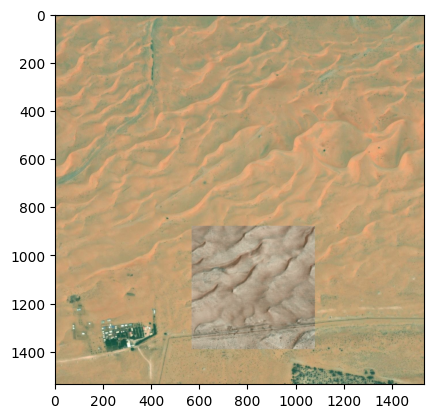

In [26]:
plt.imshow(items["overlay"][6])

In [30]:
#set random seeds for cropping as well as shuffling
torch.manual_seed(0) 
rng = np.random.default_rng(seed = 0)

sample_test_dataset = Testset(
    rgb_base_path = "datasets/rgb_zone2.png",
    thermal_patches= thermal_patches,
    centers=centers,
    num_samples = 100
)

sample_test_dataloader = DataLoader(sample_test_dataset,batch_size=10, drop_last=False, shuffle=True)

In [31]:
items = next(iter(sample_test_dataloader))

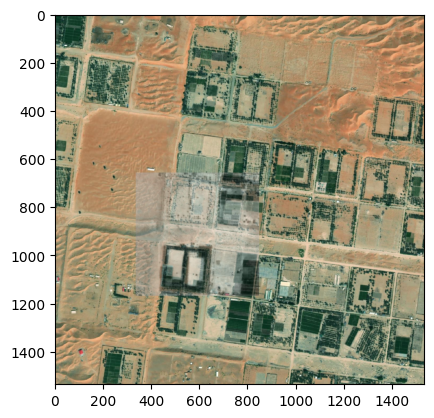

In [35]:
plt.imshow(items["overlay"][0])